In [0]:
pip install pandas hdbscan plotly python-dotenv umap-learn -q

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:

#general
import numpy as np
import pandas as pd
from ast import literal_eval

#graficar
import matplotlib.pyplot as plt
import plotly.express as px

#Modelos
from sklearn.cluster import DBSCAN, KMeans
import hdbscan
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn import cluster
from sklearn.model_selection import RandomizedSearchCV


#metricas
from sklearn.manifold import trustworthiness
from sklearn.metrics import make_scorer


In [0]:
%run /Workspace/Users/arestrepo15@summa-sci.com/proyecto_integrador/connection_datalake

## cargar dataset con embeddings

In [0]:
path = "df_split_250_embeddings_videos_youtube.csv"
file_path = f"abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/{path}"
df_youtube_data = spark.read.option("header", True) \
                           .option("inferSchema", True) \
                           .option("sep", ";") \
                           .csv(file_path)

[FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/dataset_videos_youtube_embeddings.csv', name='dataset_videos_youtube_embeddings.csv', size=689874729, modificationTime=1715291158000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/dataset_videos_youtube_embeddings_300_tokens.csv', name='dataset_videos_youtube_embeddings_300_tokens.csv', size=1924220793, modificationTime=1717730763000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/dataset_videos_youtube_embeddings_500_tokens.csv', name='dataset_videos_youtube_embeddings_500_tokens.csv', size=1292213144, modificationTime=1717730158000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/df_curated_videos_youtube.csv', name='df_curated_videos_youtube.csv', size=91124952, modificationTime=1717729824000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/df_split_250_embeddings_videos_youtube.csv', n

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np
import ast

# Definir la UDF para convertir la cadena de texto a un array de floats
def convert_to_array(embedding_str):
    return np.array(ast.literal_eval(embedding_str), dtype=float).tolist()

convert_to_array_udf = udf(convert_to_array, ArrayType(DoubleType()))

# Aplicar la UDF a la columna 'embedding'
df_youtube_data = df_youtube_data.withColumn("embedding", convert_to_array_udf(df_youtube_data["embedding"]))

In [0]:
df_youtube_data_2023 = df_youtube_data.filter(df_youtube_data['year'] == 2023)

In [0]:
df_youtube_data_2024 = df_youtube_data.filter(df_youtube_data['year'] == 2024)

## Adecuar embeddings para ser usados como predictores de los modelos

In [0]:
embeddings = np.array(df_youtube_data_2024.select("embedding").rdd.map(lambda row: row[0]).collect())

In [0]:
embeddings.shape

(19431, 1536)

## CLUSTERING

## K-Means

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Optimal number of clusters: 2


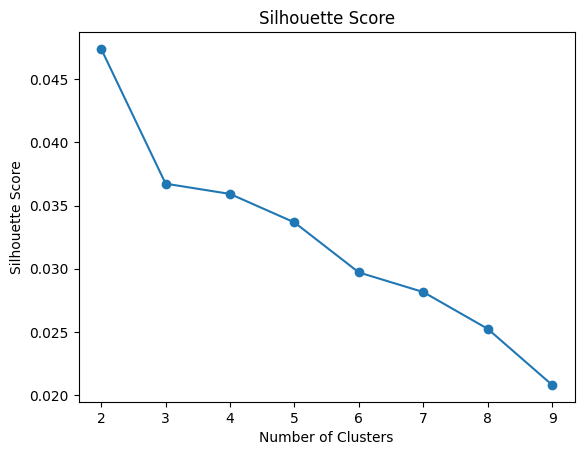

In [0]:
silhouette_scores = []
cluster_range = range(2, 10)  # Silhouette Score is not defined for 1 cluster

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(embeddings)
    labels = kmeans.labels_
    score = silhouette_score(embeddings, labels,metric='euclidean')
    silhouette_scores.append(score)

best_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", best_n_clusters)

plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

Optimal number of clusters: 2


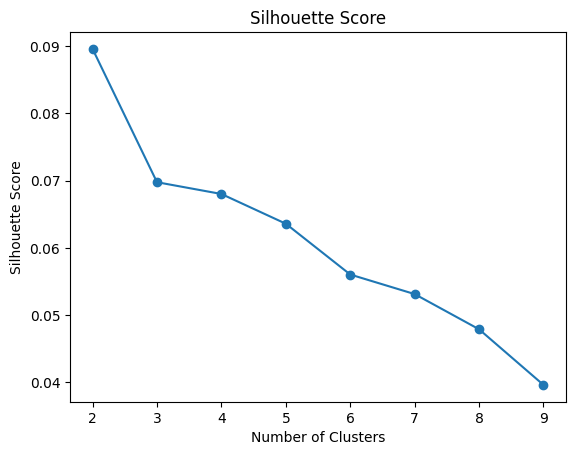

In [0]:
silhouette_scores = []
cluster_range = range(2, 10)  # Silhouette Score is not defined for 1 cluster

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(embeddings)
    labels = kmeans.labels_
    score = silhouette_score(embeddings, labels,metric='cosine')
    silhouette_scores.append(score)

best_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", best_n_clusters)

plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

In [0]:
n_clusters=best_n_clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings)
kmeans_labels=kmeans.labels_

In [0]:
tsne_model= TSNE(n_components=2, random_state=42, perplexity=100, metric='cosine')
tsne_embeddings= tsne_model.fit_transform(embeddings)
fig = px.scatter(
    x=tsne_embeddings[:,0],
    y=tsne_embeddings[:,1],
    color=kmeans_labels,
    title="Clustering",
    width=900,
    height=900,
    color_discrete_sequence=px.colors.qualitative.G10_r
    )
fig.show()

In [0]:
from umap import UMAP
# Ajuste del modelo UMAP
umap_model = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)

# Graficar los resultados utilizando Plotly
fig = px.scatter(
    x=umap_embeddings[:,0],
    y=umap_embeddings[:,1],
    color=kmeans_labels,
    title="Clustering con UMAP",
    width=900,
    height=900,
    color_discrete_sequence=px.colors.qualitative.G10_r
)
fig.show()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d3c5e51e-01d1-4c86-8472-834058ff4e23/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d3c5e51e-01d1-4c86-8472-834058ff4e23/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.



In [0]:
# Definir el modelo DBSCAN
dbscan = DBSCAN(n_jobs=-1 )
dbscan_labels = dbscan.fit_predict(embeddings)
print(silhouette_score(embeddings, dbscan_labels, metric = "cosine"))

0.15155959145497214


In [0]:
# Graficar los resultados utilizando Plotly
fig = px.scatter(
    x=umap_embeddings[:,0],
    y=umap_embeddings[:,1],
    color=dbscan_labels,
    title="Clustering con UMAP",
    width=900,
    height=900,
    color_discrete_sequence=px.colors.qualitative.G10_r
)
fig.show()

In [0]:
# evalute the clusters
labels = dbscan.labels_
clustered = (labels >= 0)
    
coverage = np.sum(clustered) / embeddings.shape[0]
total_clusters = np.max(labels) + 1
cluster_sizes = np.bincount(labels[clustered]).tolist()

print(f"Percent of data retained: {coverage}")
print(f"Total Clusters found: {total_clusters}")
print(f"Cluster splits: {cluster_sizes}")

Percent of data retained: 0.9824507230713808
Total Clusters found: 10
Cluster splits: [18985, 31, 8, 8, 10, 16, 5, 8, 10, 9]


In [0]:
# Definir el modelo DBSCAN
dbscan = DBSCAN(eps = 0.1, min_samples= 50, metric ='cosine', n_jobs=-1 )
dbscan_labels = dbscan.fit_predict(embeddings)
print(silhouette_score(embeddings, dbscan_labels, metric = "cosine"))



0.05767773725588888


In [0]:
# evalute the clusters
labels = dbscan.labels_
clustered = (labels >= 0)
    
coverage = np.sum(clustered) / embeddings.shape[0]
total_clusters = np.max(labels) + 1
cluster_sizes = np.bincount(labels[clustered]).tolist()

print(f"Percent of data retained: {coverage}")
print(f"Total Clusters found: {total_clusters}")
print(f"Cluster splits: {cluster_sizes}")

Percent of data retained: 0.5928156039318615
Total Clusters found: 1
Cluster splits: [11519]


In [0]:
from hdbscan.validity import validity_index
print(f"validity index: {validity_index(embeddings, dbscan_labels)}")

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d3c5e51e-01d1-4c86-8472-834058ff4e23/lib/python3.10/site-packages/hdbscan/validity.py:30: RuntimeWarning:

overflow encountered in power

/databricks/python/lib/python3.10/site-packages/numpy/core/_methods.py:48: RuntimeWarning:

overflow encountered in reduce



validity index: nan


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d3c5e51e-01d1-4c86-8472-834058ff4e23/lib/python3.10/site-packages/hdbscan/validity.py:407: RuntimeWarning:

invalid value encountered in double_scalars



In [0]:
# Graficar los resultados utilizando Plotly
fig = px.scatter(
    x=umap_embeddings[:,0],
    y=umap_embeddings[:,1],
    color=dbscan_labels,
    title="Clustering con UMAP",
    width=900,
    height=900,
    color_discrete_sequence=px.colors.qualitative.G10_r
)
fig.show()

In [0]:
# Definir los valores de eps y min_samples
eps_values = np.linspace(0.1, 1.0, 5)
min_samples_values = [5, 10, 50, 100, 200]

# Crear un DataFrame para almacenar los resultados
results_dbscan_df = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette_score', 'percent_data_retained', 'total_clusters', 'cluster_sizes'])

# Iterar sobre los valores de eps y min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Entrenar el modelo DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        dbscan_labels = dbscan.fit_predict(embeddings)
        
        # Calcular métricas
        labels = dbscan.labels_
        clustered = (labels >= 0)
        if len(set(labels))>1:
            silhouette= silhouette_score(embeddings, labels , metric = "cosine")
        else:
            silhouette = None
        coverage = np.sum(clustered) / embeddings.shape[0]
        total_clusters = np.max(labels) + 1
        cluster_sizes = np.bincount(labels[clustered]).tolist()

        # Number of clusters in labels, ignoring noise if present.

        n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

         # Crear un DataFrame temporal para el resultado actual
        temp_df = pd.DataFrame({
            'eps': [eps],
            'min_samples': [min_samples],
            'silhouette_score': [silhouette],
            'percent_data_retained': [coverage],
            'total_clusters': [total_clusters],
            'cluster_sizes': [cluster_sizes]
        })
        
        # Concatenar el DataFrame temporal al DataFrame principal
        results_dbscan_df = pd.concat([results_dbscan_df, temp_df], ignore_index=True)

In [0]:
# Mostrar el DataFrame con los resultados
results_dbscan_df

,eps,min_samples,silhouette_score,percent_data_retained,total_clusters,cluster_sizes
0,0.100,5,NaN,0.000000,0,[]
1,0.100,10,NaN,0.000000,0,[]
2,0.100,50,NaN,0.000000,0,[]
3,0.100,100,NaN,0.000000,0,[]
4,0.100,200,NaN,0.000000,0,[]
5,0.325,5,-0.050902,0.004735,3,"[77, 10, 5]"
6,0.325,10,-0.005849,0.003808,1,[74]
7,0.325,50,None,0.000000,0,[]
8,0.325,100,None,0.000000,0,[]
9,0.325,200,None,0.000000,0,[]


In [0]:
# Definir los valores de eps y min_samples
eps_values = np.linspace(0.1, 1.0, 5)
min_samples_values = [5, 10, 50, 100, 200]

# Crear un DataFrame para almacenar los resultados
results_dbscan_df_2 = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette_score', 'percent_data_retained', 'total_clusters', 'cluster_sizes'])

# Iterar sobre los valores de eps y min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Entrenar el modelo DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        dbscan_labels = dbscan.fit_predict(embeddings)
        
        # Calcular métricas
        labels = dbscan.labels_
        clustered = (labels >= 0)
        if len(set(labels))>1:
            silhouette= silhouette_score(embeddings, labels , metric = "cosine")
        else:
            silhouette = None
        coverage = np.sum(clustered) / embeddings.shape[0]
        total_clusters = np.max(labels) + 1
        cluster_sizes = np.bincount(labels[clustered]).tolist()

         # Crear un DataFrame temporal para el resultado actual
        temp_df = pd.DataFrame({
            'eps': [eps],
            'min_samples': [min_samples],
            'silhouette_score': [silhouette],
            'percent_data_retained': [coverage],
            'total_clusters': [total_clusters],
            'cluster_sizes': [cluster_sizes]
        })
        
        # Concatenar el DataFrame temporal al DataFrame principal
        results_dbscan_df_2 = pd.concat([results_dbscan_df_2, temp_df], ignore_index=True)


In [0]:
# Mostrar el DataFrame con los resultados
results_dbscan_df_2

,eps,min_samples,silhouette_score,percent_data_retained,total_clusters,cluster_sizes
0,0.100,5,-0.052812,0.712007,30,"[13621, 11, 22, 16, 6, 2, 5, 9, 5, 5, 11, 6, 5..."
1,0.100,10,0.065831,0.679944,4,"[13175, 10, 17, 10]"
2,0.100,50,0.057678,0.592816,1,[11519]
3,0.100,100,0.050104,0.530441,1,[10307]
4,0.100,200,0.036611,0.438629,1,[8523]
5,0.325,5,None,1.000000,1,[19431]
6,0.325,10,None,1.000000,1,[19431]
7,0.325,50,None,1.000000,1,[19431]
8,0.325,100,None,1.000000,1,[19431]
9,0.325,200,None,1.000000,1,[19431]


In [0]:
dbscan = DBSCAN(eps=0.1, min_samples=10, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings)

In [0]:
# Reducir la dimensionalidad de los embeddings a 2D con UMAP
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d3c5e51e-01d1-4c86-8472-834058ff4e23/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



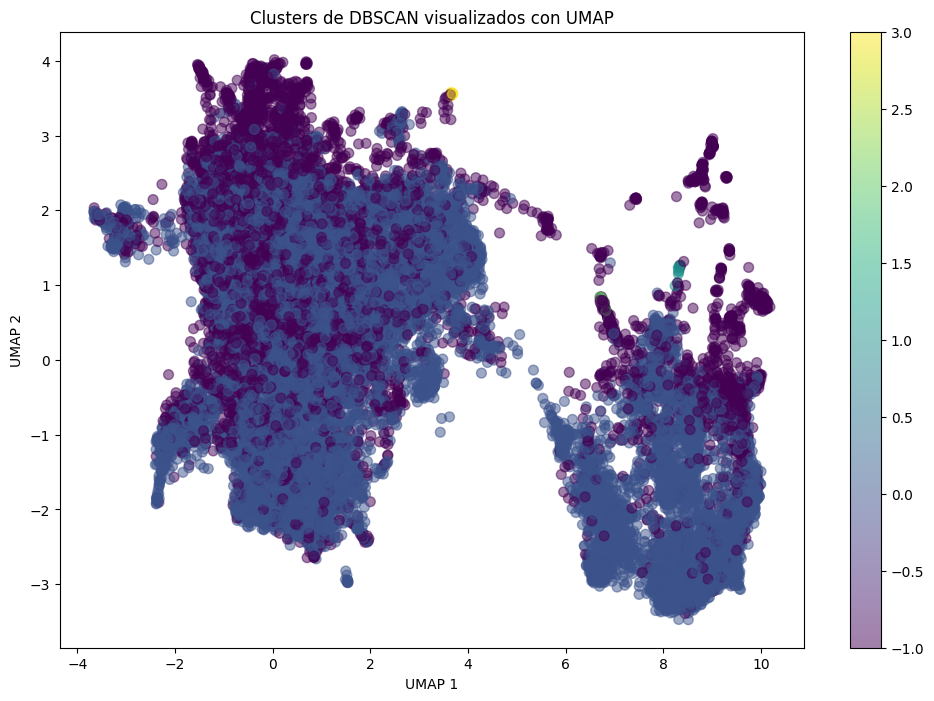

In [0]:
# Graficar los clusters de DBSCAN
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.5)
plt.colorbar()
plt.title('Clusters de DBSCAN visualizados con UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [0]:
# Convertir el DataFrame de Spark a un DataFrame de pandas
df_youtube_data_2024_pd = df_youtube_data_2024.toPandas()

# Agregar la columna de etiquetas al DataFrame de pandas
df_youtube_data_2024_pd['dbscan_labels'] = dbscan_labels

In [0]:
df_youtube_data_2024_pd[dbscan_labels==-1]['text'].head().values

array(['un artículo que además dentro de poco voy a empezar a publicar ahí y a recuperar siempre digo quiero recuperar mis artículos en investing con los que colaboro desde hace muchos años falta de tiempo pero ahora parece que lo voy a poder tener y también voy a publicar en ya les diré en dónde donde mismo lo hace este señor y otros artículos que yo les he ido trayendo en inglés en estados unidos vamos a ver cómo nos va verdad a ver si damos ese saltito bueno siguiente diapositiva aquí lo que nos viene a decir es lo siguiente sectores que siguen ofreciendo oportunidades pero se recomienda cautela debido a la posibilidad de que se produzca un re inicio del mercado un un reinicio traducido así del inglés es una corrección ir a buscar liquidez sabemos que los índices están ahora mismo al borde de esto precisamente no bueno dice que el entorno económico actual es favorable para las acciones y la reserva federal no indica prisa por recortar los tipos eso lo tenemos claro por eso se ha que

In [0]:
df_youtube_data_2024_pd[dbscan_labels==0]['text'].head().values

array(['por qué comprar ahora google y esperar un poco para comprar bitcoin. saludos cordiales bienvenido a bolsas hoy martes 2 de abril bueno tenemos muchos mercados que están corrigiendo estamos viendo a bitcoin en la serie de 4 horas pero pasaremos enseguida a los análisis porque además hoy desde el punto de vista fundamental vamos a conocer datos desde estados unidos datos relevantes que pueden mover a cualquiera de los dos lados a las bolsas vamos a ver cómo te voy a ir contando toda esta historia porque quiero que saqu es una conclusión o al menos que tengas en perspectiva que todo lo que lees todo lo que escucha y todo lo que ves no tiene siempre por qué tener la razón o ser bueno vamos por pasos porque es que vienes buscando aquí algún análisis eh buscando una oportunidad de negociar vamos a empezar por lo siguiente este señor pertenece a un grupo de inversión como puedes ver líder de un grupo de inversión david lerner verdad un artículo que he encontrado de él que dice que la 

In [0]:
df_youtube_data_2024_pd[dbscan_labels==1]['text'].head().values

array(['la deuda mundial está en niveles récord y puede destruir la economía. de dónde sacan los países el dinero para pagar su defensa sus servicios públicos y todo lo que hace falta para mantener un país en funcionamiento bueno un estado tiene muchas maneras de financiarse todo gobierno puede cobrarle impuestos a sus ciudadanos y a sus empresas las empresas públicas de un país pueden dar beneficios los estados pueden vender sus recursos naturales e incluso los bancos centrales pueden imprimir dinero para financiarse aunque este coste se lo pasarán a sus ciudadanos en forma de inflación si sin embargo muchas veces estas fuentes de financiación no dan para que los gobiernos puedan pagar todas sus facturas por ello otra forma que tienen los gobiernos de conseguir dinero y además es muy común es emitir deuda pública o dicho de otra manera pedir dinero prestado a otros países a instituciones internacionales a empresas e incluso a ciudadanos de todo el mundo hay mucha gente que se cree que

In [0]:
df_youtube_data_2024_pd[dbscan_labels==2]['text'].head().values

array(['y mejor un saludo',
       'generado nos quedamos con esta imagen será más y mejor un saludo',
       'saludo y hasta la próxima', 'y mejor un saludo',
       'mañana que como siempre será más y mejor y si te vas de vacaciones que lo pases muy bien y al regreso aquí estamos será más y mejor un saludo'],
      dtype=object)

In [0]:
df_youtube_data_2024_pd[dbscan_labels==3]['text'].head().values

array(['sobre las amenazas de usar armas nucleares orma noche difícil para jarkov ojo con esto queene tiene una parte muy importante que es la que vamos a desarrollar ojo con esta noticia dice el expresidente ruso dimitri melbeck dijo el viernes o sea hoy que el kremlin no está mintiendo ojo con esto que el kremlin no está mintiendo sobre sus amenazas de utilizar armas nucleares tácticas contra ucrania y continúo leyendo atención noticia de última hora usted debe prepararse de la forma en que usted considere con sus posiciones en los mercados que tenga no estoy diciendo vendan nada sino mucha atención mucha atención y continúo leyendo dice en una publicación traducida por google voy a señalar esto en una publicación traducida por google en su canal oficial de telegram el expresidente de rusia dijo que el uso de armas nucleares tácticas por parte de moscú puede calcularse mal ahí lo dice entre comillas pero la posición del kremlin sobre el posible despliegue de esas armas no era ni inti